# Using GSKY to replace datacube

### This notebook will demonstrate the use of GSKY to retrieve and display landsat data.

#### Example 1

In this example we will manually type in a bounding box to display the GSKY layer, or select from a list of hard coded bounding boxes.

Instead of writing the GSKY output into a NetCDF file and then reading it back into Xarray, this example uses the **diskless** NetCDF that eliminates the disk I/O. Though it is quite unnecessary to do so in a single datafile situation, it is nevertheless given here to demonstrate the capability.

The data is in **netCDF4.\_netCDF4.Dataset** format. A drawback of plotting the values directly from it is that only one band per image can be plotted (cf. three bands together when using Xarray). Converting the in-memory data into Xarray Dataset does not work.

###### Specifics

- Converting a DEA notebook example to use GSKY instead of datacube.
- Uses WCS to get an area from a specified layer/date/bbox/time, and differs from the DEA example where an area around a single point is calculated ("LoadingCloudfreeSentinel2andLandsat.ipynb").
- Identifying an area which has data is a challenge. 
    - Hence, a number of BBoxes, which are known to have data are hard coded. 
    - Selecting a date will auto select the correct BBox.
- This example can only use one sensor ("ls8") instead of three sensors as DEA has used.
- Only one time slice can be used in WCS. 
    - You can choose from all available times in the layer.
    - Only 2 time slices have valid BBoxes hard coded. 
    - The fourth uses the whole of Australia.
- If you can determine a valid BBox for a date (Tip: Use TerriaMap) it can be manually typed in.
- The DEA example, using datacube, can get the data for a time range. It is not possible in GSKY.

**Author:** Arapaut V. Sivaprasad

**Date:** 17 December, 2019

### How to use

Use this notebook to display a GSKY layer corresponding to a time slice and bounding box (BBox). Instead of manually typing in the BBox, you can select a time to use hard coded BBoxes.

- Specify the name of layer in cell 2
    - layer = "landsat8_nbar_16day"
    - If necessary, uncomment a code block to see all available layers.

- Identify the available time positions (dates of data acquisitions) in cell 3
    - Give m,n values to display the range of dates (from 0 to n_times-1)
    - Give t=i to say which date to use (from 0 to n_times-1).

- If you know another BBox with data (Tip: use TerriaMap to find) then type it in as,
    - bbox = (130.00, -27.00, 131.00, -29.00)

- Execute all cells from top to bottom.

In [2]:
##########################################################
# Author: Arapaut V. Sivaprasad.                         #
# Dates: Created: 18/10/2019; Last Modified: 17/12/2019  #
##########################################################
from owslib.wcs import WebCoverageService
from netCDF4 import Dataset
import matplotlib.pylab as plt
%matplotlib inline

### GSKY server and layer name

The GSKY Capability Endpoint URL is specified in the cell below. A layer must also be hard coded. You can display all layers in the dataset and choose any layer.

In [3]:
# Specify the GSKY production URL here. The layer is hard coded
gsky_url = 'https://gsky.nci.org.au/ows/dea'
wcs = WebCoverageService(gsky_url, version='1.0.0')
layer = "landsat8_nbar_16day"

# Uncomment below to see all layers.

#for layer in list(wcs.contents):
#    print ("Layer Name:", layer)
#    print ("Title:", wcs[layer].title, '\n')

### Time position

To get the data it is necessary to send a single time position. You can uncomment a line to display all vailable time positions.

In [4]:
# To display the available time slices in any range, specify the start and end values as m,n below
time = wcs[layer].timepositions
n_times = len(time)
m = 0
n = n_times

# Unlike in the case of datacube, where a time range can be specified, GSKY requires a specific date.
# This time slice is specified below. 
t = 0

# Uncomment the line below to see all time positions.
#print ("Total of", n_times,'timepositions:\n\n', time[m:n])
print(time[t])

2013-03-19T00:00:00.000Z


### Construct a boundong box

To get the data from GSKY it is necessary to send the request with a layer, time and bounding box. In the cell below the bounding box can be manually typed in or selected from a list.  

In [5]:
# Specify a 2D array of BBoxes as west, north, east, south in EPSG:4326
w = 10;
BBoxes = [0 for x in range(w)] 
BBoxes[0] = ['140.00,-27.01,141.00,-29.00']
BBoxes[1] = ['130.00,-27.00,131.00,-29.00']
BBoxes[2] = ['150.00,-27.00,151.00,-29.00']
#BBoxes[3] = ['112.47,-11.14,154.02,-43.59'] # Australia
bbox = BBoxes[t]

# If you know another BBox containing data (Tip: use TerriaMap to find out) then type it in below.
#bbox = ['130.00,-27.00,131.00,-29.00']

x = float(bbox[0][0:6])
y = float(bbox[0][7:13])
X = float(bbox[0][14:20])
Y = float(bbox[0][21:27])
X = float('%.2f'%(x + ((abs(Y - y) / 220) * 337)))
bbox = (x,y,X,Y)
bbox

(140.0, -27.01, 143.05, -29.0)

### Construct the GSKY end point URL

The GSKY capability endpoint URL is constructed below. You must specify a style ('fc' or 'tc'). 

#### DO NOT write the data into a file

The GSKY server returns the data in NetCDF format which is read into the variable, nc, in memory. It is NOT written to the disk.

In [7]:
# Construct a WCS call to GSKY and send it.
filename = 'dtemp.nc'
output = wcs.getCoverage(identifier=layer, Styles='fc',
                         time=[wcs[layer].timepositions[t]],
                         bbox=bbox,format='NetCDF',
                         crs='EPSG:4326', width=256, height=256)

# Read the output into diskless NetCDF
nc = Dataset(filename,'r',diskless=True,persist=False, memory=output.read())

### Plot the individual bands

Unlike with Xarray data, the bands can only be plotted separately. 

<function matplotlib.pyplot.show(*args, **kw)>

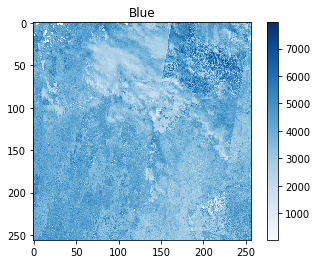

In [8]:
band1 = nc.variables['Band1'][:]
plt.imshow(band1, cmap='Blues')
plt.title('Blue')
plt.colorbar()
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

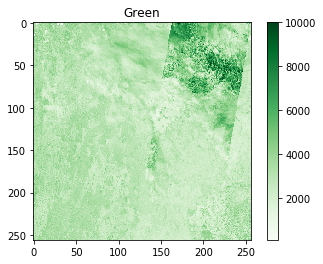

In [9]:
band2 = nc.variables['Band2'][:]
plt.imshow(band2, cmap = 'Greens')
plt.title('Green')
plt.colorbar()
plt.show


<function matplotlib.pyplot.show(*args, **kw)>

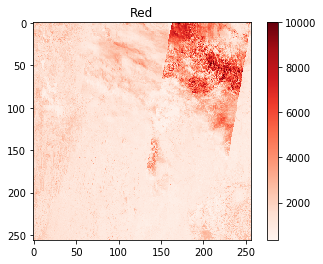

In [10]:
band3 = nc.variables['Band3'][:]
plt.imshow(band3, cmap = 'Reds')
plt.colorbar()
plt.title('Red')
plt.show

### Development Notes
(Not to be included in final version)

- There is some doubt about the accuracy of data coming from GSKY. The three bands show essentially the same pattern except for the intensity of the dots. One would expect that an area with more Green should show less or nil Red.

- A combined three-band plot should look like as in 'DEA_to_GSKY_Example_1'

- Reading the *netCDF4.\_netCDF4.Dataset* in memory into xarray Dataset gives the error, **Attribute not found**. Scouring the web for a solution to the problem did not come up with an answer.

#### __END_____OF_____NOTEBOOK
***